In [1]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Notebooks/BKAI/Sentiment Analysis/Data/VI_IMDB.csv")
df['vi_review'].head(10)

0    Một trong những người đánh giá khác đã đề cập ...
1    Một sản phẩm nhỏ tuyệt vời. <br /><br />Kỹ thu...
2    Tôi nghĩ đây là một cách tuyệt vời để dành thờ...
3    Về cơ bản, có một gia đình mà một cậu bé (Jake...
4    "Love in the Time of Money" của Petter Mattei ...
5    Có lẽ là bộ phim yêu thích nhất mọi thời đại c...
6    Tôi chắc chắn muốn thấy sự hồi sinh của loạt p...
7    Chương trình này là một ý tưởng tuyệt vời, mới...
8    Được khuyến khích bởi những bình luận tích cực...
9    Nếu bạn thích những tràng cười sảng khoái nguy...
Name: vi_review, dtype: object

In [4]:
df.head()

,review,sentiment,vi_review
0,One of the other reviewers has mentioned that ...,positive,Một trong những người đánh giá khác đã đề cập ...
1,A wonderful little production. <br /><br />The...,positive,Một sản phẩm nhỏ tuyệt vời. <br /><br />Kỹ thu...
2,I thought this was a wonderful way to spend ti...,positive,Tôi nghĩ đây là một cách tuyệt vời để dành thờ...
3,Basically there's a family where a little boy ...,negative,"Về cơ bản, có một gia đình mà một cậu bé (Jake..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"""Love in the Time of Money"" của Petter Mattei ..."


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
def encode_sentiment(sentiment):
  if sentiment=="positive":
    return 1
  else:
    return 0

df['sentiment'] = df['sentiment'].apply(encode_sentiment)

In [9]:
df['sentiment'].head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

# Data preprocessing

We need to tokenize the text and convert to numerical values. For BERT, this need more attention.

Here are the requirements:

- Add special tokens and do classification (PAD, UNK,...)
- Pass sequence of fixed length
- Create array of 0s (pad) and 1s (unk) known as attention mask


In [10]:
from transformers import AutoTokenizer, AutoModel

model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
token_lens = []

for txt in df['vi_review']:
  tokens = tokenizer.encode(txt, max_length=256)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

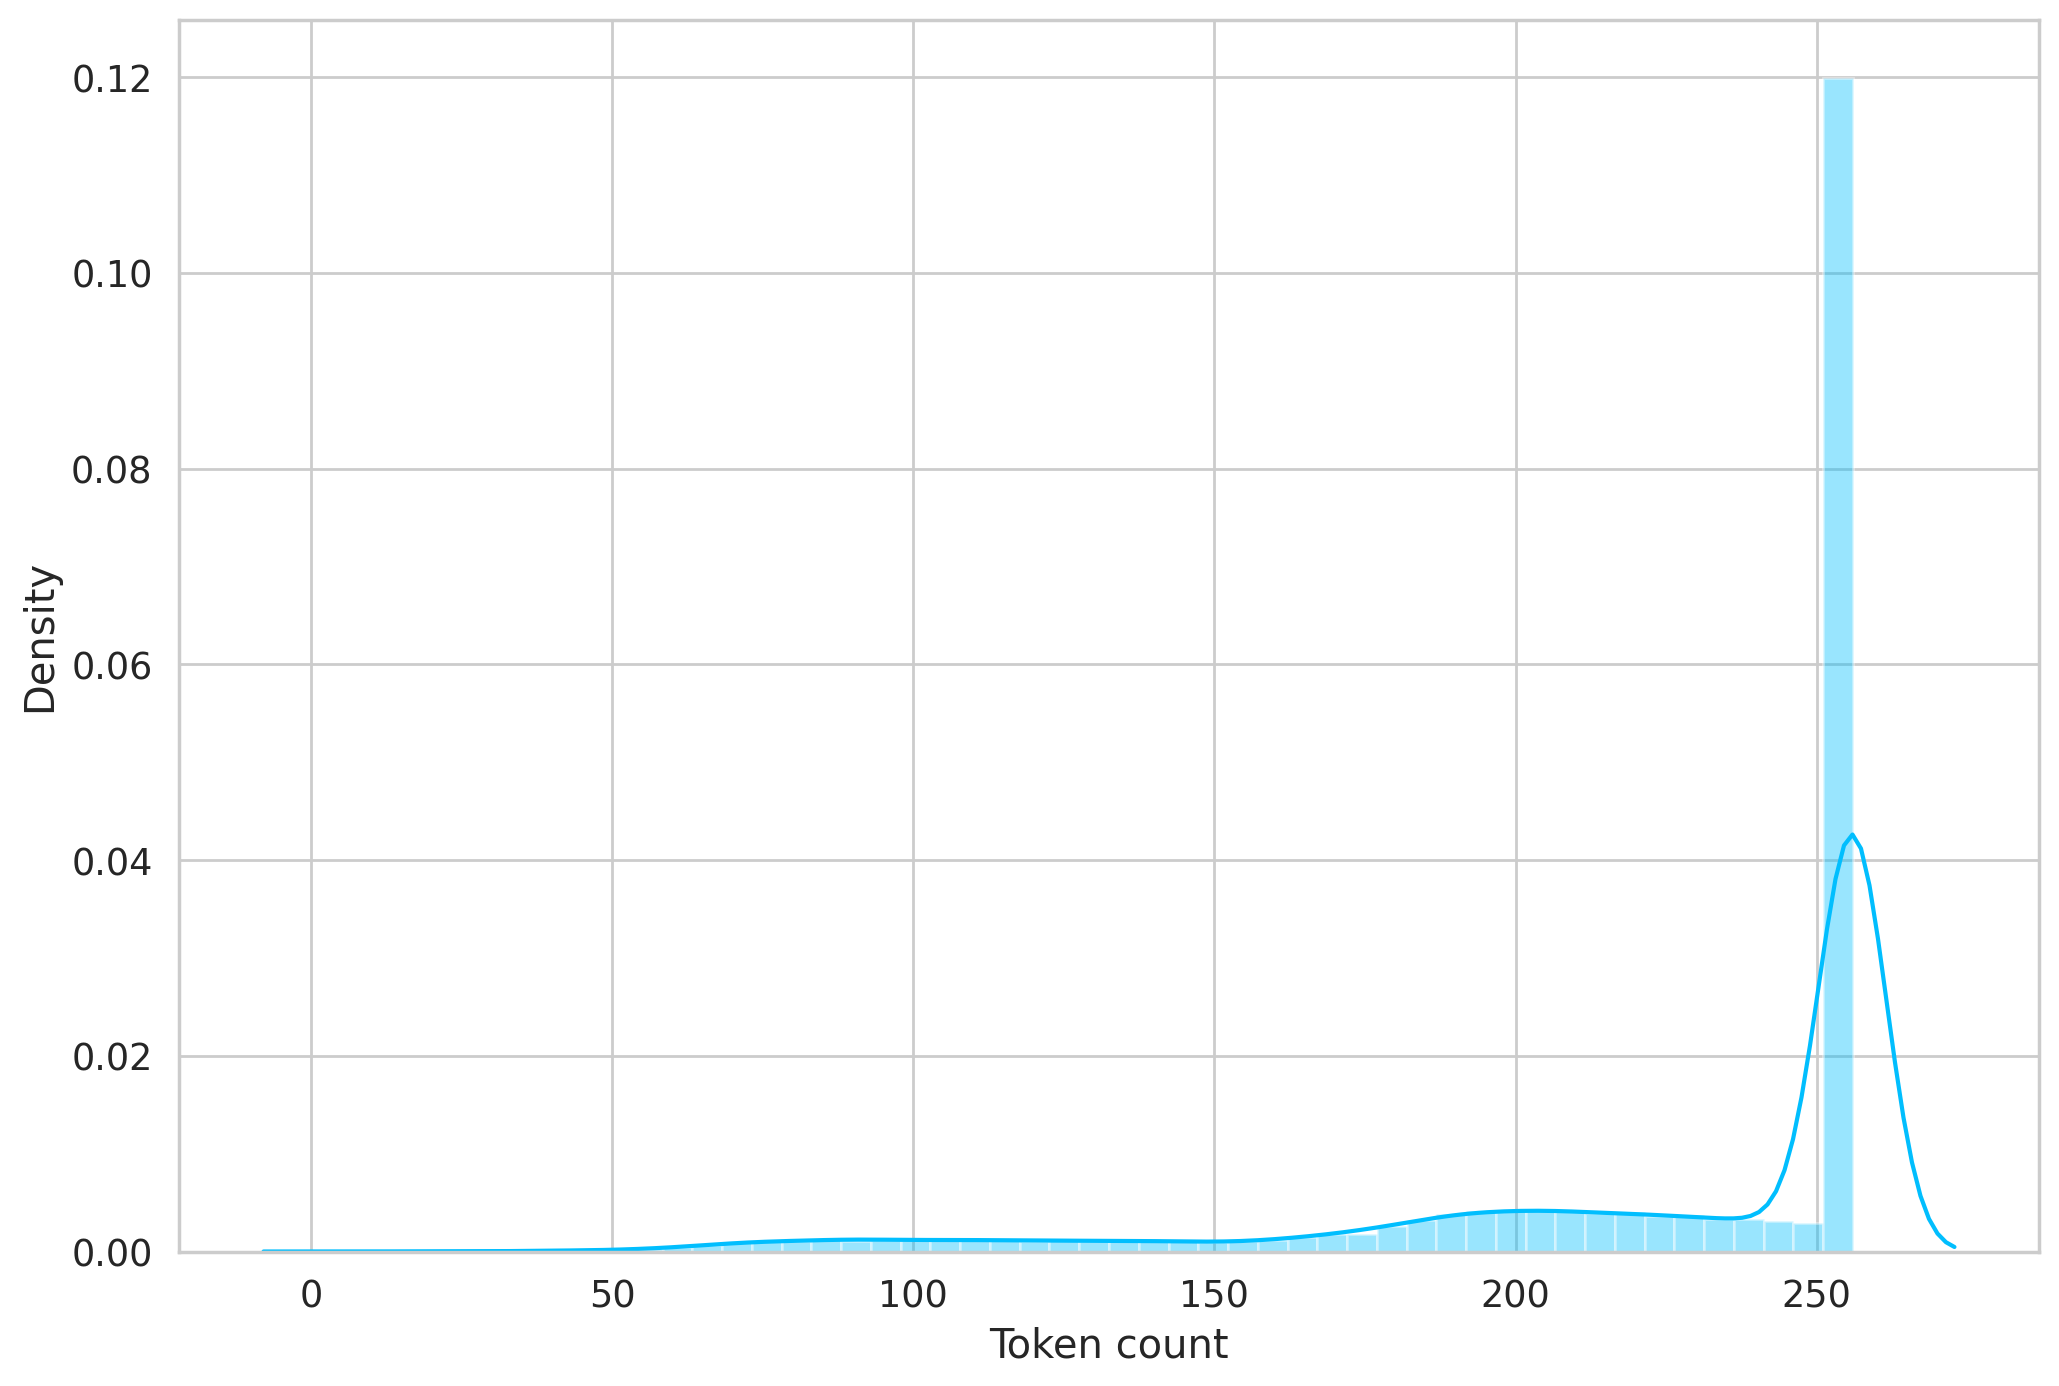

In [12]:
sns.distplot(token_lens)
plt.xlabel('Token count')

In [13]:
# most tokens are pretty long, we choose max length to be 300
MAX_LEN = 256

In [14]:
print(tokenizer.encode(df['vi_review'][0], max_length=256))

[0, 242, 12, 21, 18, 480, 133, 85, 14, 1294, 5530, 87, 53, 26, 305, 66, 99, 834, 22921, 4, 88, 38, 45, 1088, 42245, 13208, 783, 96, 59324, 1701, 4, 90, 97, 159, 2906, 8, 21, 148, 14, 254, 40, 15, 15359, 11816, 63117, 15945, 7269, 61542, 63117, 15945, 7269, 61542, 432, 127, 6937, 122, 70, 4903, 2634, 28, 54075, 8, 61, 8493, 14457, 6, 21, 805, 14457, 2792, 17, 1019, 21688, 1301, 10615, 1701, 4, 4623, 380, 249, 39, 1196, 1782, 9827, 2858, 70, 29027, 4, 97, 17, 41, 8, 16, 5887, 1893, 365, 13, 21, 18, 1783, 1714, 118, 2008, 4718, 2008, 5796, 13208, 6041, 1893, 23, 17, 10, 1486, 7410, 142, 2657, 2665, 30, 2006, 36117, 1581, 4, 939, 9970, 118, 14457, 45267, 21473, 1244, 8, 1094, 58162, 1701, 4, 63, 139, 5717, 8410, 862, 18445, 7, 39, 46521, 63117, 15945, 7269, 61542, 63117, 15945, 7269, 61542, 1244, 11, 328, 8, 1345, 6114, 90, 37, 8, 7311, 5255, 11, 320, 13, 9502, 2943, 1706, 58, 2234, 11759, 3507, 2529, 8822, 16122, 1236, 5, 1244, 834, 2765, 286, 1783, 33, 1206, 835, 2265, 6103, 59741, 4, 16

# Dataset class

In [15]:
class IMDBDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, idx):
    review = str(self.reviews[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
train, testval = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
val, test = train_test_split(testval, test_size=0.5, random_state=RANDOM_SEED)
print(train.shape)

(40000, 3)


In [17]:
print(val.shape)

(5000, 3)


## DataLoader

In [18]:
train_data = IMDBDataset(train.to_numpy(),
                         train['sentiment'].to_numpy(),
                         tokenizer=tokenizer,
                         max_len=MAX_LEN)

val_data = IMDBDataset(val.to_numpy(),
                         val['sentiment'].to_numpy(),
                         tokenizer=tokenizer,
                         max_len=MAX_LEN)

test_data = IMDBDataset(test.to_numpy(),
                         test['sentiment'].to_numpy(),
                         tokenizer=tokenizer,
                         max_len=MAX_LEN)

train_dataloader = DataLoader(train_data, batch_size=16, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=16, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=16, num_workers=0)

In [19]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [20]:
data = next(iter(train_dataloader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


# Model

In [21]:
model = AutoModel.from_pretrained(model_name)

In [22]:
# Fine tune the pretrained model require us to change the FC layer
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.phobert = AutoModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.phobert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.phobert(
        input_ids = input_ids,
        attention_mask=attention_mask,
        return_dict=False
    )

    output = self.drop(pooled_output)
    return self.out(output)

In [23]:
model = SentimentClassifier(n_classes=2)
model = model.to(device)

## Train


In [24]:
!pip install wandb

In [25]:
import wandb
wandb.init(
    project="bkai-sentiment",
    name = "phobert"
)

wandb: Currently logged in as: shinosukien. Use `wandb login --relogin` to force relogin


In [26]:
EPOCHS = 5
LR = 2e-5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
from tqdm import tqdm
def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
  model.train()
  losses = []
  correct_preds = 0

  for d in tqdm(dataloader):
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    optimizer.zero_grad()
    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_preds += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
  return correct_preds.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
for d in train_dataloader:
  print(len(d['targets']))
  break

16


## Train loop

In [ ]:
best_accuracy = 0
import time
for epoch in range(EPOCHS):
    t1 = time.time()
    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(val)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()
    print(f"Train time for epoch {epoch+1}: {time.time() - t1}")
    wandb.log({"Train Acc": train_acc, "Train Loss": train_loss, "Val Acc": val_acc, "Val Loss": val_loss})

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.pt')
        best_accuracy = val_acc

Epoch 1/5
----------


100%|██████████| 2500/2500 [32:29<00:00,  1.28it/s]


Train loss 0.6983411358833314 accuracy 0.499475


100%|██████████| 313/313 [01:26<00:00,  3.61it/s]


Val loss 0.6942435464919946 accuracy 0.5002

Train time for epoch 1: 2035.8147642612457
Epoch 2/5
----------


100%|██████████| 2500/2500 [32:17<00:00,  1.29it/s]


Train loss 0.6956748240470886 accuracy 0.503


100%|██████████| 313/313 [01:26<00:00,  3.63it/s]


Val loss 0.6943017465237993 accuracy 0.5002

Train time for epoch 2: 2023.809271812439
Epoch 3/5
----------


100%|██████████| 2500/2500 [32:16<00:00,  1.29it/s]


Train loss 0.6955928513050079 accuracy 0.49870000000000003


100%|██████████| 313/313 [01:25<00:00,  3.65it/s]


Val loss 0.6935716996939418 accuracy 0.5002

Train time for epoch 3: 2022.0597820281982
Epoch 4/5
----------


 84%|████████▍ | 2104/2500 [27:10<05:12,  1.27it/s]